## Набор данных "Forest Fires"
 - X - координата по оси Х на карте парка Монтесиньо (от 1 до 9)
 - Y - координата по оси Y на карте парка Монтесиньо (от 2 до 9)
 - month - месяц года (от 'jan' до 'dec')
 - day - день недели (от 'mon' до 'sun')
 - FFMC - индекс содержания влаги в горючих материалах (от 18.7 до 96.20)
 - DMC - индекс содержания влаги в лесной подстилке на небольшой глубине (от 1.1 до 291.3)
 - DC - индекс засухи, индекс влажности глубоких слоев почвы (7.9 до 860.6)
 - ISI - индекс ожидаемых темпов распространения огня (от 0.0 до 56.10)
 - temp - температура в градусах Цельсия (от 2.2 до 33.30)
 - RH - относительная влажность в % (от 15.0 до 100)
 - wind - скорость ветра в км/ч (от 0.40 до 9.40)
 - rain - количество осадков в мм/м2 (от 0.0 до 6.4)
 - area - площадь выгоревшего леса в га (от 0.00 до 1090.84) (эта выходная переменная сильно отклонена в сторону 0.0. Поэтому имеет смысл моделировать с помощью преобразования логарифма)

## Предобработка данных

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [3]:
#Загружаем набор данных
df = pd.read_csv("forestfires.csv", sep=",", low_memory=False)

In [4]:
#Проверяем, что дадасет корректно загрузился
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [5]:
# Укажем тип данных для категориальных параметров
df['X'] = df.X.astype('category')
df['Y'] = df.Y.astype('category')
df['month'] = df.month.astype('category')
df['day'] = df.day.astype('category')

In [6]:
#Смотрим, что типы правильно преобразовались
df.dtypes

X        category
Y        category
month    category
day      category
FFMC      float64
DMC       float64
DC        float64
ISI       float64
temp      float64
RH          int64
wind      float64
rain      float64
area      float64
dtype: object

In [7]:
#Смотрим описание данных
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [8]:
# Проверяем, есть ли пропуски
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [9]:
#Сформируем набор числовых данных
cont_df = df.select_dtypes(include=["int64", "float64"])

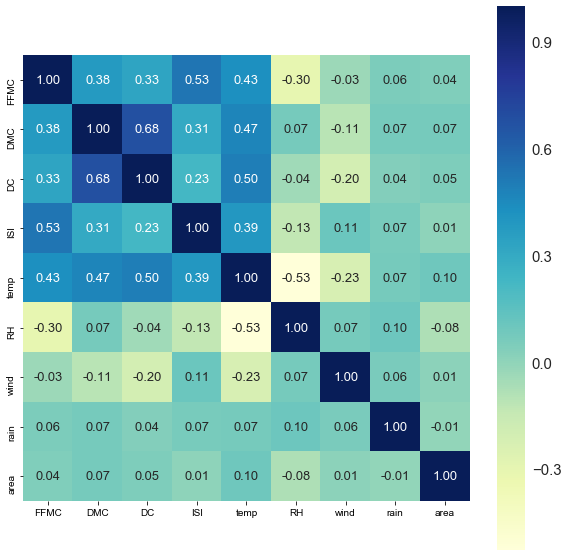

In [10]:
# Построим тепловую карту для визуализации корреляции между числовыми параметрами
plt.subplots(figsize=(10,10)) 
sns.set(font_scale=1.5) 
hm = sns.heatmap(df.corr(), 
                 cbar=True,
                 annot=True,
                 annot_kws={'size': 13},
                 square=True,
                 fmt='.2f',
                 cmap="YlGnBu")
plt.show()

In [11]:
# Мы видим, что признаки DC и DMC имеют сильную взаимную корреляцию. Чтобы эта взаимная корреляция не искажала картину, 
# удалим один из признаков.
df = df.drop(['DMC'], axis=1)

In [12]:
# Закодируем категориальные переменные
# прямое кодирование категориальных переменных
res_df = pd.get_dummies(df)
res_df

,FFMC,DC,ISI,temp,RH,wind,rain,area,X_1,X_2,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,86.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0,0,...,0,0,0,1,0,0,0,0,0,0
1,90.6,669.1,6.7,18.0,33,0.9,0.0,0.00,0,0,...,0,1,0,0,0,0,0,0,1,0
2,90.6,686.9,6.7,14.6,33,1.3,0.0,0.00,0,0,...,0,1,0,0,0,1,0,0,0,0
3,91.7,77.5,9.0,8.3,97,4.0,0.2,0.00,0,0,...,0,0,0,1,0,0,0,0,0,0
4,89.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,0,...,0,0,0,0,0,0,1,0,0,0
5,92.3,488.0,14.7,22.2,29,5.4,0.0,0.00,0,0,...,0,0,0,0,0,0,1,0,0,0
6,92.3,495.6,8.5,24.1,27,3.1,0.0,0.00,0,0,...,0,0,0,0,1,0,0,0,0,0
7,91.5,608.2,10.7,8.0,86,2.2,0.0,0.00,0,0,...,0,0,0,0,1,0,0,0,0,0
8,91.0,692.6,7.0,13.1,63,5.4,0.0,0.00,0,0,...,0,0,1,0,0,0,0,0,1,0
9,92.5,698.6,7.1,22.8,40,4.0,0.0,0.00,0,0,...,0,0,1,0,0,1,0,0,0,0


In [1]:
# Определим зависимые и независимые переменные
x = pd.concat([res_df.loc[:, 'FFMC' : 'rain'], 
              res_df.loc[:, 'X_1' : 'day_wed']], axis=1)
y = np.log(res_df['area'] + 1)

NameError: name 'pd' is not defined

In [14]:
# Разделим набор данных на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

In [15]:
# Выберем столбцы с числовыми значениями
train_norm = x_train[x_train.columns[0:8]]
test_norm = x_test[x_test.columns[0:8]]

In [16]:
# Стандартизируем тренировочный набор
std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)

In [17]:
# Сконвертируем numpy массив в dataframe pandas
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns) 
# Обновим тренировочный набор стандартизированными значениями
x_train.update(training_norm_col)

In [18]:
# Проверим результат стандартизации
x_train.describe()

,FFMC,DC,ISI,temp,RH,wind,rain,X_1,X_2,X_3,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
count,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,361.000000,361.000000,...,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,-3.903772e-15,1.811417e-16,-2.737115e-17,-5.535738e-17,2.583344e-16,-8.057574e-17,-1.003353e-16,1.857548e-16,0.138504,0.096953,...,0.002770,0.027701,0.335180,0.157895,0.163435,0.146814,0.174515,0.132964,0.113573,0.110803
std,1.001388e+00,1.001388e+00,1.001388e+00,1.001388e+00,1.001388e+00,1.001388e+00,1.001388e+00,1.001388e+00,0.345908,0.296304,...,0.052632,0.164342,0.472709,0.365148,0.370275,0.354412,0.380079,0.340007,0.317733,0.314324
min,-1.390262e+01,-2.235059e+00,-1.925719e+00,-2.900869e+00,-1.860699e+00,-1.955616e+00,-1.031421e-01,-3.118725e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.108546e-02,-4.251788e-01,-5.748213e-01,-5.434898e-01,-7.173590e-01,-7.099327e-01,-1.031421e-01,-3.118725e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.400699e-01,4.517313e-01,-1.737737e-01,1.151897e-01,-1.456888e-01,-5.851094e-03,-1.031421e-01,-3.118725e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.904882e-01,6.375070e-01,3.328128e-01,6.872008e-01,5.530192e-01,4.815900e-01,-1.031421e-01,-3.118725e-01,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.026166e+00,1.254168e+00,9.915740e+00,2.455235e+00,3.538408e+00,2.918796e+00,1.361476e+01,3.206439e+00,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# Стандартизируем тестовый набор данных, но используем данные о среднеквадратических отклонениях из тренировочного набора
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns) 
x_test.update(testing_norm_col)

In [20]:
# Проверим результат стандартизации
x_test.describe()

,FFMC,DC,ISI,temp,RH,wind,rain,X_1,X_2,X_3,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,...,156.0,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,-0.145664,-0.083612,-0.071076,-0.026591,-0.001143,0.012202,0.361659,0.048980,0.147436,0.128205,...,0.0,0.032051,0.326923,0.179487,0.096154,0.198718,0.205128,0.083333,0.147436,0.089744
std,1.191696,1.047020,0.866509,1.021239,1.116795,0.897487,5.057209,1.070854,0.355682,0.335395,...,0.0,0.176704,0.470600,0.384996,0.295752,0.400320,0.405096,0.277276,0.355682,0.286735
min,-7.796265,-2.229331,-1.841287,-2.554195,-1.670143,-1.684815,-0.103142,-0.311872,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.148874,-0.591211,-0.553714,-0.647492,-0.971435,-0.709933,-0.103142,-0.311872,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.140070,0.433317,-0.131558,-0.023480,-0.209208,-0.005851,-0.103142,-0.311872,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.390488,0.655102,0.396136,0.570199,0.632418,0.752391,-0.103142,-0.311872,0.000000,0.000000,...,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.026166,1.232480,2.844637,2.489902,3.474889,2.647995,62.607270,3.206439,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Линейный регрессор

In [37]:
lin_reg = LinearRegression(n_jobs = -1)

In [38]:
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [39]:
y_pred_linear = lin_reg.predict(x_test)

In [40]:
np.sqrt(mean_squared_error(y_test, y_pred_linear))

1.5455197070571904

In [41]:
mean_absolute_error(y_test, y_pred_linear)

1.2088764192025219

In [42]:
r2_score(y_test, y_pred_linear)

-0.23348079852248893

In [51]:
print('Linear Model Estimation:')
print('R2_score_Lin: ',round(r2_score(y_test,y_pred_linear),2))
print('MSE_lin: ',round(mean_squared_error(y_test,y_pred_linear),2))
print('MAE_Lin: ',round(mean_absolute_error(y_test,y_pred_linear),2))

Linear Model Estimation:
R2_score_Lin:  -0.23
MSE_lin:  2.39
MAE_Lin:  1.21


## Полиномиальный регрессор

In [146]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(x_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [147]:
y_pred_poly = pol_reg.predict(X_poly)

In [148]:
np.sqrt(mean_squared_error(y_train, y_pred_poly))

0.31159630003400141

In [149]:
mean_absolute_error(y_train, y_pred_poly)

0.19144366575443214

In [150]:
r2_score(y_train, y_pred_poly)

0.95039190933160145

In [151]:
print('Polynomial Model Estimation:')
print('R2_score_Poly: ',round(r2_score(y_train, y_pred_poly),2))
print('MSE_Poly: ',round(mean_squared_error(y_train, y_pred_poly),2))
print('MAE_Poly: ',round(mean_absolute_error(y_train, y_pred_poly),2))

Polynomial Model Estimation:
R2_score_Poly:  0.95
MSE_Poly:  0.1
MAE_Poly:  0.19


## Случайный лес

In [86]:
#Используем RandomizedSearchCV для получения оптимальных значений гиперпараметров
RFR= RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = -1) 
param_grid = { 
    'max_features' : ["auto", "sqrt", "log2"],
    'min_samples_split' : np.linspace(0.1, 1.0, 10),
    'max_depth' : [x for x in range(1,20)]}
    
CV_RFR = RandomizedSearchCV(estimator=RFR, param_distributions = param_grid, n_jobs = -1, cv= 10, n_iter = 50)
CV_RFR.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [87]:
# Получим лучшие гиперпараметры
CV_RFR.best_params_

{'max_depth': 2,
 'max_features': 'auto',
 'min_samples_split': 0.59999999999999998}

In [88]:
CV_RFR.best_score_

-0.062072480522073571

In [89]:
# Обучим новую модель с лучшими гиперпараметрами
RFR_ = RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = -1, min_samples_split = 0.10000000000000001, max_features = 'sqrt', max_depth = 1) 
RFR_.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.1,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [85]:
RFR_.feature_importances_

array([ 0.054,  0.07 ,  0.048,  0.132,  0.062,  0.108,  0.024,  0.004,
        0.004,  0.03 ,  0.   ,  0.   ,  0.002,  0.004,  0.04 ,  0.012,
        0.038,  0.012,  0.012,  0.016,  0.012,  0.07 ,  0.01 ,  0.01 ,
        0.012,  0.07 ,  0.012,  0.   ,  0.004,  0.002,  0.012,  0.01 ,
        0.   ,  0.006,  0.002,  0.002,  0.018,  0.036,  0.016,  0.01 ,
        0.006,  0.008])

In [90]:
Ytest_pred_RF=RFR_.predict(x_test)

In [91]:
np.sqrt(mean_squared_error(y_test, Ytest_pred_RF))

1.3903447502065449

In [92]:
mean_absolute_error(y_test, Ytest_pred_RF)

1.1697493563951042

In [93]:
r2_score(y_test, Ytest_pred_RF)

0.0017753233164069515

In [94]:
print('RF Model Estimation:')
print('R2_score_RF: ',round(r2_score(y_test,Ytest_pred_RF),2))
print('MSE_RF: ',round(mean_squared_error(y_test,Ytest_pred_RF),2))
print('MAE_RF: ',round(mean_absolute_error(y_test,Ytest_pred_RF),2))

RF Model Estimation:
R2_score_RF:  0.0
MSE_RF:  1.93
MAE_RF:  1.17


## Отчет

1) 
Модель линейного регрессора справилась плохо:
Linear Model Estimation:
R2_score_Lin:  -0.23
MSE_lin:  2.39
MAE_Lin:  1.21
    
Мы видим отрицательное значение коэффициента детерминации, в то время, как значение должно раскладываться в диапазоне от 0 до 1.

2) 
Полиномиальный регрессор справился лучше. Значения полинома 3,4,5 дают следующий результат: 
Polynomial Model Estimation:
R2_score_Poly:  0.99
MSE_Poly:  0.01
MAE_Poly:  0.02

Похоже, модель переобучилась.
    
Значение полинома 2 дает следующий результат:
Polynomial Model Estimation:
R2_score_Poly:  0.95
MSE_Poly:  0.1
MAE_Poly:  0.19

При высоком значении детерминации маленькие значения средней абсолютной ошибки и средней квадратичной ошибки. Похоже, эта модель справилась лeчше всех.

3) 
Случайный лес с отобранными при помощи RandomizedSearchCV оптимальными гиперпараметрами дал следующий результат:
RF Model Estimation:
R2_score_RF:  0.0
MSE_RF:  1.93
MAE_RF:  1.17
    
При нулевом значении детерминации относительно небольшие значения средней абсолютной ошибки и средней квадратичной ошибки. 
Едва ли можно считать этот результат хорошим. 